In [1]:
import os.path

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)

## Read in Protein Structure
1. We will start by reading in a set of Protein structures with the given Protein ID "pfam_id"
    * [More Info on working with PDB structures in DataFrames](http://rasbt.github.io/biopandas/tutorials/Working_with_PDB_Structures_in_DataFrames/)

In [2]:
data_path = Path('/home', 'eclay','Pfam-A.full')
data_path = Path('Pfam-A.full')
DCA_ER_dir = Path('/home/evan/PycharmProjects/DCA_ER/')

pfam_id = 'PF00023'
pfam_id = 'PF00011'
pfam_id = 'PF00186'

n_jobs = 6


# Set DCA_ER directory
DCA_dir = os.getcwd()

# Define data directories
# Need to think on best way to do this..
# Referencing the same dataframe may be useful so we dont always have to load individual ref files...
# however we also
individual_pdb_ref_file = Path(data_path, pfam_id, 'pdb_refs.npy')
pdb = np.load(individual_pdb_ref_file)
processed_data_dir = "%s/protein_data/data_processing_output" % DCA_dir

# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])


# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
pdb_df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_end',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
pdb_df.head()


number of pdb structures: 372


,PF,seq,id,uniprot_start,uniprot_end,pdb_id,chain,pdb_start,pdb_end
0,PF00186,69,Q5KZ26_GEOKA,1,160,1ZDR,B,1,160
1,PF00186,69,Q5KZ26_GEOKA,1,160,1ZDR,A,1,160
2,PF00186,83,Q81R22_BACAN,2,160,3JWK,B,2,160
3,PF00186,83,Q81R22_BACAN,2,160,3S9U,B,2,160
4,PF00186,83,Q81R22_BACAN,2,160,3FL9,H,2,160


PDB DataFrame needs to have PF######, PDB-id, as well as start and end locations of amino acids, as well as reference sequence in msa (not in current file with all pdb data)
### PDB Website Search Engine
   * We can visualize the complex structure of the proteins
   * The data-base below gives further information on the proteins above (input pdb_id)

### Define contact map
2. Import contact map functions from newly defined tools python module

In [3]:
import ecc_tools as tools

In [4]:
ipdb = 0
printing = False
print('seq:',int(pdb[ipdb,1]))




# data processing
s0,cols_removed, s_index, tpdb, orig_seq_len = data_processing(data_path, pfam_id, ipdb,\
                gap_seqs=0.2, gap_cols=0.2, prob_low=0.004, conserved_cols=0.9, printing=printing, out_dir=processed_data_dir)
print('\nPreprocessed reference Sequence: ', s0[tpdb])

# Load pydca trimmed datrimmed_data_outfile = '%sprotein_data/data_processing_output/MSA_%s_Trimmed.fa' % (DCA_ER_dir, pfam_id)
trimmed_msa_file = Path(DCA_ER_dir, 'protein_data/data_processing_output/MSA_%s_Trimmed.fa' % pfam_id)
s0_pydca = tools.read_FASTA(str(trimmed_msa_file), ref_index = int(pdb[ipdb,1]))

# Load csv of PDB-PFAM mapping.
#    downloaded from 
#    ftp://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/csv/pdb_pfam_mapping.csv.gz
pdb_id = pdb_df.iloc[ipdb]['pdb_id']
pdb_chain = pdb_df.iloc[ipdb]['chain']

pdb_pfam_map_file = Path('%s/protein_data/pdb_data/pdb_pfam_mapping.csv' % DCA_dir)
pdb_map_df = pd.read_csv(pdb_pfam_map_file, sep=',', header=1)
print(pdb_map_df.head())

pdb_id_map_df = pdb_map_df.loc[pdb_map_df['PDB']==pdb_id.lower()]
pdb_pfam_map = pdb_id_map_df.loc[pdb_id_map_df['CHAIN']==pdb_chain]

# print('wtf pdb length matching S sequence length ', orig_seq_len )
# for pdb_index, pdb_info in pdb_pfam_map.iterrows(): # loop trhough rows of dataframe
#     pdb_len = pdb_info['PDB_END'] - pdb_info['PDB_START']
#     print(pdb_len)
#     if pdb_len == orig_seq_len:
#         break
        
       

# Check that pdb--pfam mapping is unique
if pdb_pfam_map.shape[0] > 1:
    print('Unable to get unique PDB-->Pfam mapping')
    print(pdb_pfam_map)

# pp_range = [pdb_info['PDB_START'], pdb_info['PDB_END']]
pp_range = [pdb_pfam_map.iloc[0]['PDB_START'], pdb_pfam_map.iloc[0]['PDB_END']]
print('Polypeptide range for contact map: ', pp_range)


pdb_out = "%s/protein_data/pdb_data" % DCA_dir
# Directory for storing PDB data locally
# returns contact map with the appropriate columns removed..
# For list of retained columns us s_index
ct, ct_full, n_amino_full, poly_seq_curated = tools.contact_map(pdb, ipdb, pp_range, cols_removed, s_index, pdb_out_dir=pdb_out, printing=printing)




seq: 69
After removing bad sequences, tpdb is now  56

Preprocessed reference Sequence:  [ 7 15  6  7 17 10  2  3 11 14 17  8  2 11 14  9 12  6  9 12  0  2  9  0
 19  8 14 17 10  5  6  0  7 17  8  4  3  0  7  5 14 12 12  5  2 11 17 17
 17 16 14 11 14 15  4 14 12  3  5  1  9 17  9  6 15  9  3  3 17  8 13 18
  7  0 15 14  2  3 17  4  7  7  0  3  9  4 14  0 16 10 12  7 17  2 14  9
 19 17  8  7  4  0 15  4 12  5 16  4 19 12  7 15  2  2  3 18  3  7 17 15
 19 16 12  5  5  3  8 11 12 19  3  6  0  4  7  7 19]

Loading Fasta File
/home/evan/PycharmProjects/DCA_ER/protein_data/data_processing_output/MSA_PF00186_Trimmed.fa

Reference Sequence (index 69) :  PF00186seq
['-' '-' '-' 'L' 'I' 'V' 'A' 'Y' 'A' 'A' 'N' 'R' 'V' 'I' 'G' 'R' 'D' 'N'
 'T' 'L' 'P' 'W' 'R' 'L' 'P' 'G' 'D' 'L' 'A' 'H' 'F' 'K' 'R' 'S' 'T' 'L'
 'G' 'H' 'P' 'V' 'I' 'M' 'G' 'R' 'N' 'T' 'W' 'E' 'S' 'L' 'G' 'R' 'P' 'L'
 'P' 'G' 'R' 'L' 'N' 'I' 'V' 'I' 'S' 'R' 'N' 'S' 'E' 'Y' 'E' 'A' 'A' 'G'
 'A' 'S' 'V' 'Y' 'P' 'S' 'L' 'E' 'A' 'A' 'L

In [5]:
## Plot the contact Map of the imported Protein structure

## Now we want to use Expectation Reflection to infer the "calculate the weights " 
  * Infer interactions between residues (R-part of ammino acid) in proteins from Multiple Sequence Alignment (MSA) data
  * More understanding required on meaning/interpretation of weights
  
1. We can start by defining some important values of our protein structures
    * It is important to define 'i1i2' vector to keep track of OneHot index positions (i) coresonding to the beginning and end of a given amino acid position (this acts as a key between the OneHot matrix (s) and the original sequence matrix (s0)

In [6]:
# number of positions
n_var = s0.shape[1]
print("Number of residue positions:",n_var)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
# print("(Sanity Check) Column indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
# print("(Sanity Check) Column indices of second and (",i1i2[1],") and second to last (",i1i2[-2],") positions")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of residue positions: 137
Number of different amino acids at each position [ 6 16 12  7  8 16  8 17 12 14  9 19 11 10 13  5  5 14  9  6 11  2  9 12
 11  9 10 16 17 11 12 13  5  4  9  7 11  6  5 10 12 10  9  9 17  8  8  2
  5  2 11 11 18 18 20 20 20 14 13 15 16 15 14 14  7 12 15 12  8 15 15 21
 19 16 16 20 15 17 13 11  8 10 12 13  4  3 13 15 12 11 13 19  9 11 17  7
 14  8 16  3 16 19 15 14 15  7  7 15  7 17 10 16 20 17 18  5 17 16 17 20
 19 18 21 21 19 15 17 13 16 13 14 10 14  9 18 14  5]
Total number of variables 1702


2.  The above indices help to divide all the possible amino acids at different positions to binary choices which will be implemented wit 1 of K notation (OneHot Encoder)

In [7]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)
# print("Amino Acid sequence Matrix\n",s0)
# print("OneHot sequence Matrix\n",s)
# print("An individual element of the OneHot sequence Matrix (size:",
#      s.shape,") --> ",s[0], " has length ",s[0].shape)

#### OneHot Format example
* Given 3 sequence poitions each with 3 different amino acids:
    * Notation: The 3<sup>rd</sup> amino acid type at the 2<sup>nd</sup> sequence position is denoted as R23<br/>
* OneHot converts the sequence [R11 R22 R33] &rightarrow; [1 0 0 0 1 0 0 0 1]  
  
  
3. We next want to define our local field parameters

In [8]:
# Define wight matrix with variable for each possible amino acid at each sequence position
w = np.zeros((mx.sum(),mx.sum())) 
h0 = np.zeros(mx.sum())

### Apply Expectation Reflection
4. We can now apply expectation reflection to infer the connection between postion residues

In [9]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

In [10]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1


if os.path.exists("%s_w.npy" % pfam_id):
# if 0:
    w = np.load("%s_w.npy" % pfam_id)
else:
    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    res = Parallel(n_jobs = n_jobs)(delayed(predict_w)\
    #res = Parallel(n_jobs = 32)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    ## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
    ## python implementation or just wrong
    #----------------niter_max,l2)

    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    #res = Parallel(n_jobs = 8)(delayed(predict_w)\
    res = Parallel(n_jobs = 32)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    ## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
    ## python implementation or just wrong
    #-------------------------------
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]

        h01 = res[i0][0]
        w1 = res[i0][1]

        h0[i1:i2] = h01
        w[:i1,i1:i2] = w1[:i1,:]
        w[i2:,i1:i2] = w1[i1:,:]

    # make w symmetric
    w = (w + w.T)/2.



5. Now we want to plot a heat map of our sequence weights

In [11]:
# Verify that w is symmetric (sanity test)
print("Dimensions of w: ",w.shape)
w_file = "%s_w.npy" % pfam_id
np.save(w_file, w)

Dimensions of w:  (1702, 1702)


6. Plot relationship between sequence positions via Direct information

In [12]:
di = direct_info(s0,w)
print(di)
print(di.shape)
print(len(s_index))

from ecc_tools import score_APC
sequence_length = pp_range[1] - pp_range[0]

# RunE ER di scores through Average Product Correction (to combat influences of phylogeny)
er_APC = score_APC(di, sequence_length, s_index)
di_apc = tools.di_dict2mat(er_APC, cols_removed, s_index)

[[0.         0.12108442 0.01953771 ... 0.00559979 0.00500477 0.00608626]
 [0.12108442 0.         0.02589521 ... 0.00498496 0.01090644 0.00874225]
 [0.01953771 0.02589521 0.         ... 0.00524939 0.00557046 0.00739682]
 ...
 [0.00559979 0.00498496 0.00524939 ... 0.         0.03688425 0.10573652]
 [0.00500477 0.01090644 0.00557046 ... 0.03688425 0.         0.0962098 ]
 [0.00608626 0.00874225 0.00739682 ... 0.10573652 0.0962098  0.        ]]
(137, 137)
137
[  1   2   3   4   5   7   8   9  10  11  12  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  31  32  33  35  36  37  38  39  40  44  46
  47  48  49  50  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  90  91  92  93  94  95  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 115 116 117 118 119 120 121 122 124 125
 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 146
 147 148 149 150 151 152 153 1

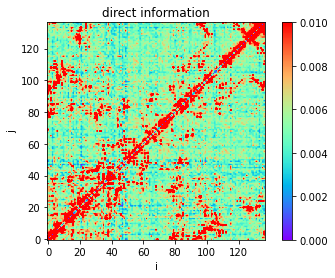

In [13]:
plt.title('direct information')
plt.imshow(di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

# Plotting ER and DCA
### Plot ER

(137, 137)
(137, 137)
ER auc max: 4.823529411764706 0.9291027234357931

Contact threshold:  4.823529411764706


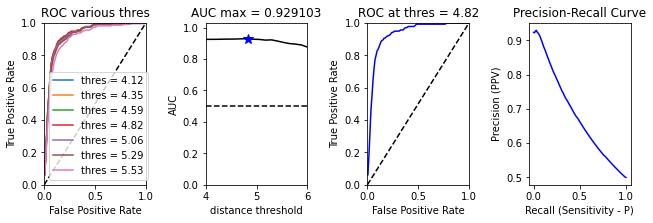

In [14]:
#print("Direct Information from Expectation reflection:\n",di)
ER_di = di
print(ER_di.shape)

# print("Direct Information from Expectation reflection:\n",di)

from ecc_tools import roc_curve
# find optimal threshold of distance
ct_thres = np.linspace(4.,6.,18,endpoint=True)
n = ct_thres.shape[0]
ct_mat = ct
print(ct.shape)
# Initialize plotting
iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

# Initalize ROC-curve tile
plt.subplot2grid((1,4),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')

# Find ct_threshold (2-6 Angstrom) which gives best contact prediction for ER
auc_ER = np.zeros(n)
for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, ER_di, ct_thres[i])
        if i in iplot:
            plt.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_ER[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_ER[i] = 0

# Get ER method's best contact prediction
i0_ER = np.argmax(auc_ER)
print('ER auc max:',ct_thres[i0_ER],auc_ER[i0_ER])
p0_ER,tp0_ER,fp0_ER = tools.roc_curve(ct_mat,ER_di,ct_thres[i0_ER])

# ROC-curve tile settings
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()


# Plot ROC, AUC and Precision for best ER contact prediction
# AUC
plt.subplot2grid((1,4),(0,1))
plt.title('AUC max = %f' %(auc_ER[i0_ER]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_ER,'k-')
plt.plot(ct_thres[i0_ER],auc_ER[i0_ER], 'b*', markersize=10.)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc_ER.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
# ROC
plt.subplot2grid((1,4),(0,2))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0_ER]))
plt.plot(fp0_ER,tp0_ER,'b-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Precision-Recall
plt.subplot2grid((1,4),(0,3))
plt.title('Precision-Recall Curve')
print('\nContact threshold: ', ct_thres[i0_ER])
plt.plot( p0_ER,tp0_ER / (tp0_ER + fp0_ER), 'b-', label='thres = %s'%ct_thres[i0_ER])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

plt.tight_layout(h_pad=1, w_pad=1.5)
# tools.hide_toggle()



### Now we want to generate DI from original DCA method for comparison
* Want to compare AUC
* Want to compare using figure S6 (#sequences required)

### Plot DCA 

auc max: 4.823529411764706 0.8981615614023173


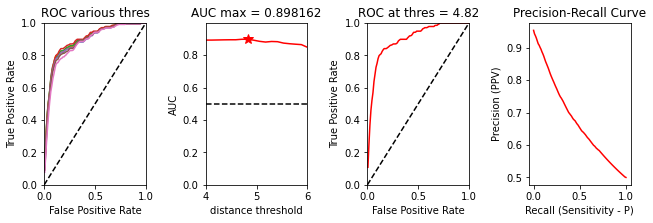

In [15]:
from inference_dca import direct_info_dca
MF_di, fij, c, cinv = direct_info_dca(s0)


# Run our version of MF di scores through Average Product Correction (to combat influences of phylogeny)
# mf_APC = score_APC(MF_di, sequence_length, s_index)
# MF_di = tools.di_dict2mat(mf_APC, cols_removed, s_index)
plt.figure(figsize=(9.0,3.2))

plt.subplot2grid((1,4),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')

# find optimal threshold of distance
auc_MF = np.zeros(n)

for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, MF_di, ct_thres[i])
        if i in iplot:
            plt.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_MF[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_MF[i] = 0
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
        
i0_MF = np.argmax(auc_MF)
print('auc max:',ct_thres[i0_MF],auc_MF[i0_MF])
p0_MF,tp0_MF,fp0_MF = tools.roc_curve(ct,MF_di,ct_thres[i0_MF])


plt.subplot2grid((1,4),(0,1))
plt.title('AUC max = %f' %(auc_MF[i0_MF]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_MF,'r-')
plt.plot(ct_thres[i0_MF],auc_MF[i0_MF], 'r*', markersize=10.)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc_MF.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')

plt.subplot2grid((1,4),(0,2))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0_MF]))
plt.plot(fp0_MF,tp0_MF,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot2grid((1,4),(0,3))
plt.title('Precision-Recall Curve')
plt.plot(p0_MF, tp0_MF / (tp0_MF + fp0_MF), 'r-', label='thres = %s'%ct_thres[i0_MF])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

plt.tight_layout(h_pad=1, w_pad=1.5)


## Compare Optimal MF and ER
* Taking the optimal threshold for each gives comparable accuracy
* ER Has higher accuracy

[-0.00056689  0.02324263 -0.00056689 -0.00056689 -0.00056689 -0.00056689
 -0.00056689 -0.00056689 -0.00150584 -0.00056689 -0.00341713 -0.00056689
 -0.00056689 -0.00056689 -0.00056689 -0.00056689 -0.00056689 -0.00056689
 -0.00056689 -0.00056689]
[-0.00056689  0.02324263 -0.00056689 -0.00056689 -0.00084047 -0.00056689
 -0.00056689 -0.00552394 -0.00056689 -0.00370342 -0.00067134 -0.00056689
 -0.00056689 -0.00056689 -0.00056689 -0.00056689 -0.00056689 -0.00191772
 -0.00056689 -0.00056689]
(3200, 3200)
(2740, 2740)
(12720, 20, 20)
(137, 137, 21, 21)
DI shape (full size) (160, 160)
DI shape (scores removed) (137, 137) 
(should be same as ER di shape..)
DI shape (full size) (160, 160)
DI shape (scores removed) (137, 137) 
(should be same as ER di shape..)
auc max: 4.470588235294118 0.9579229516428157
auc max: 4.470588235294118 0.8943131590494326


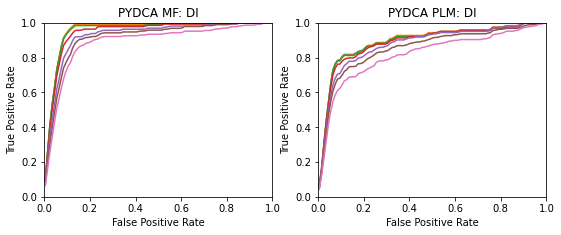

In [23]:
DCA_ER_dir = '/home/ecresswell/DCA_ER/'
DCA_ER_dir = '/home/evan/PycharmProjects/DCA_ER/'

out_dir = '%sprotein_data/di/' % DCA_ER_dir
method = "DI"
# Load pydca score pseudo-dictionaries and generate di matrices from them..
mf_score_file = '%s%s_%s_pydca_mf_preproc.npy' % (out_dir, pfam_id, method)
plm_score_file = '%s%s_%s_pydca_plm_preproc.npy' % (out_dir, pfam_id, method)

# list of di scores length of: seq_len choose 2 
# (ie for PF00186 with sequence length 160, this should be length 160 choose 2 = 12720)
mf_scores = np.load(mf_score_file, allow_pickle=True)
plm_scores = np.load(plm_score_file, allow_pickle=True)

# Load pydca data for comparison


reg_fij = np.load('%s%s_pydca_fij_preproc.npy' % (out_dir, pfam_id))
corr_mat = np.load('%s%s_pydca_corr_preproc.npy' % (out_dir, pfam_id))                                                                             
couplings = np.load('%s%s_pydca_couplings_preproc.npy' % (out_dir, pfam_id))        
fields_ij = np.load('%s%s_pydca_fields_preproc.npy' % (out_dir, pfam_id))
print(corr_mat[1][:20])
print(c[1][:20])
print(corr_mat.shape)
print(c.shape)
print(reg_fij.shape)
print(fij.shape)

# print(len(mf_fn_apc))
# print(MF_di.shape)
# print(mf_fn_apc[:5])

pydca_MF_di = tools.di_dict2mat(mf_scores, cols_removed, s_index)
pydca_PLM_di = tools.di_dict2mat(plm_scores, cols_removed, s_index)

# Get best auc for PYDCA mf and plm (and plot the ROC curves)


plt.figure(figsize=(9.0,3.2))

plt.title('ROC for PYDCA scores')

# PYDCA-MF
auc_pydca_MF = np.zeros(n)

ax1 = plt.subplot2grid((1,2),(0,0))
for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, pydca_MF_di, ct_thres[i])
        if i in iplot:
            ax1.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_pydca_MF[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_MF[i] = 0
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('PYDCA MF: %s' % method)
        
i0_pydca_MF = np.argmax(auc_pydca_MF)
print('auc max:',ct_thres[i0_pydca_MF],auc_pydca_MF[i0_pydca_MF])
p0_pydca_MF,tp0_pydca_MF,fp0_pydca_MF = tools.roc_curve(ct,pydca_MF_di,ct_thres[i0_pydca_MF])


# PYDCA-PLM
auc_pydca_PLM = np.zeros(n)

ax2 = plt.subplot2grid((1,2),(0,1))
for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, pydca_PLM_di, ct_thres[i])
        if i in iplot:
            ax2.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_pydca_PLM[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_pydca_PLM[i] = 0
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('PYDCA PLM: %s' %method)
        
i0_pydca_PLM = np.argmax(auc_pydca_PLM)
print('auc max:',ct_thres[i0_pydca_PLM],auc_pydca_PLM[i0_pydca_PLM])
p0_pydca_PLM,tp0_pydca_PLM,fp0_pydca_PLM = tools.roc_curve(ct,pydca_PLM_di,ct_thres[i0_pydca_PLM])


In [ ]:
print('ER auc max:',ct_thres[i0_ER],auc_ER[i0_ER])
print('DCA auc max:',ct_thres[i0_MF],auc_MF[i0_MF])

print('PYDCA MF auc max:',ct_thres[i0_pydca_MF],auc_pydca_MF[i0_pydca_MF])
print('PYDCA PLM auc max:',ct_thres[i0_pydca_PLM],auc_pydca_PLM[i0_pydca_PLM])

In [ ]:
plt.figure(figsize=(12.0,3.2))

# Plot ROC for optimal DCA vs optimal ER
plt.subplot2grid((1,3),(0,0))
plt.title('ROC at thres (MF, ER)\n = (%3.2f, %3.2f)'%(ct_thres[i0_MF],ct_thres[i0_ER]))
plt.plot(fp0_ER,tp0_ER,'b-',label="ER")
plt.plot(fp0_MF,tp0_MF,'r-',label="MF")
plt.plot(fp0_pydca_MF,tp0_pydca_MF,'ro',label="PYDCA MF", markersize=1)
plt.plot(fp0_pydca_PLM,tp0_pydca_PLM,'go',label="PYDCA PLM", markersize=1)

plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot AUC for DCA and ER
plt.subplot2grid((1,3),(0,1))
plt.title('AUC (MF, ER) max\n = (%3.2f, %3.2f)' %(auc_MF[i0_MF], auc_ER[i0_ER]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_ER,'b-',label="ER")
plt.plot(ct_thres,auc_MF,'r-',label="MF")
plt.plot(ct_thres,auc_pydca_MF,'ro',label="PYDCA MF", markersize=1)
plt.plot(ct_thres,auc_pydca_PLM,'go',label="PYDCA PLM", markersize=1)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,max(auc_MF.max(), auc_ER.max())+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
plt.legend()

# Plot Precision of optimal DCA and ER
plt.subplot2grid((1,3),(0,2))
plt.title('Precision at thres \n(MF, ER) = (%3.2f, %3.2f)'%(ct_thres[i0_MF],ct_thres[i0_ER]))
plt.plot( p0_ER,tp0_ER / (tp0_ER + fp0_ER),'b-',label='ER thres = %3.2f'%ct_thres[i0_ER])
plt.plot( p0_MF,tp0_MF / (tp0_MF + fp0_MF),'r-',label='MF thres = %3.2f'%ct_thres[i0_MF])
plt.plot( p0_pydca_MF,tp0_pydca_MF / (tp0_pydca_MF + fp0_pydca_MF),'ro',label='PYDCA MF %s thres = %3.2f' % (method, ct_thres[i0_pydca_MF]), markersize=1)
plt.plot( p0_pydca_PLM,tp0_pydca_PLM / (tp0_pydca_PLM + fp0_pydca_PLM),'go',label='PYDCA PLM %s thres = %3.2f' % (method, ct_thres[i0_pydca_PLM]), markersize=1)

plt.plot([0,1.],[.5,.5],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')
plt.legend()

plt.tight_layout(h_pad=1, w_pad=1.5)

plt.savefig('ERvPYDCA_%s_comparison.pdf' % method)


# tools.hide_toggle()